In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, matthews_corrcoef, roc_auc_score, confusion_matrix
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

# Load the dataset
dataset = pd.read_excel('Final_non_redundant_sequences.xlsx', na_filter=False)
X_data_name = 'whole_sample_dataset_esm2_t30_150M_UR50D_unified_640_dimension.csv'
X_data = pd.read_csv(X_data_name, header=0, index_col=0, delimiter=',')
X = np.array(X_data)
y = np.array(dataset['label'])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def build_model(input_shape):
    input = Input(input_shape)
    x = Conv1D(64, 5, strides=1, padding='same')(input)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Conv1D(128, 5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input, outputs=x)
    return model

def step_decay(epoch):
    initial_lr = 0.01
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lr

def train_model(X_train, y_train, X_test, y_test):
    input_shape = (640, 1)
    model = build_model(input_shape)
    
    # Optimizer
    adam = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    lrate = LearningRateScheduler(step_decay)
    early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, restore_best_weights=True)
    mc = ModelCheckpoint('best_model_640.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    callbacks_list = [lrate, early_stop, mc]
    
    class_weight = {0: 1, 1: 2}  # Adjust the weights as needed
    
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=callbacks_list, batch_size=32, class_weight=class_weight)
    
    return model

# Train the model
trained_model = train_model(X_train, y_train, X_test, y_test)

# Load the best model
saved_model = load_model('best_model_640.h5')

# Function to optimize threshold based on MCC
def optimize_threshold(y_true, y_pred_probas):
    thresholds = np.arange(0.1, 1.0, 0.05)
    best_mcc = -1
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (y_pred_probas > threshold).astype(int)
        mcc = matthews_corrcoef(y_true, y_pred)
        
        if mcc > best_mcc:
            best_mcc = mcc
            best_threshold = threshold
    
    return best_threshold, best_mcc




Epoch 1/100


137/137 [==============================] - ETA: 0s - loss: 9.5649 - accuracy: 0.7990
Epoch 1: val_accuracy improved from -inf to 0.25365, saving model to best_model_640.h5
137/137 [==============================] - 7s 41ms/step - loss: 9.5649 - accuracy: 0.7990 - val_loss: 5.1860 - val_accuracy: 0.2536 - lr: 0.0100
Epoch 2/100


C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


137/137 [==============================] - ETA: 0s - loss: 0.5297 - accuracy: 0.8677
Epoch 2: val_accuracy did not improve from 0.25365
137/137 [==============================] - 5s 38ms/step - loss: 0.5297 - accuracy: 0.8677 - val_loss: 3.4243 - val_accuracy: 0.2536 - lr: 0.0100
Epoch 3/100
137/137 [==============================] - ETA: 0s - loss: 0.4894 - accuracy: 0.8686
Epoch 3: val_accuracy did not improve from 0.25365
137/137 [==============================] - 5s 38ms/step - loss: 0.4894 - accuracy: 0.8686 - val_loss: 1.6071 - val_accuracy: 0.2536 - lr: 0.0100
Epoch 4/100
137/137 [==============================] - ETA: 0s - loss: 0.4791 - accuracy: 0.8811
Epoch 4: val_accuracy improved from 0.25365 to 0.61953, saving model to best_model_640.h5
137/137 [==============================] - 6s 40ms/step - loss: 0.4791 - accuracy: 0.8811 - val_loss: 0.7452 - val_accuracy: 0.6195 - lr: 0.0100
Epoch 5/100
137/137 [==============================] - ETA: 0s - loss: 0.4831 - accuracy: 0.87

In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, confusion_matrix
import math

k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=1)

# Convert back to DataFrames if needed (assuming X_train is still a numpy array)
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

# Result collection lists
ACC_collection = []
BACC_collection = []
Sn_collection = []
Sp_collection = []
MCC_collection = []
AUC_collection = []

# Function to train the model for each fold
def ESM_CNN(X_train_CV, y_train_CV, X_valid_CV, y_valid_CV):
    # Train the model with the training fold
    model = train_model(X_train_CV, y_train_CV, X_valid_CV, y_valid_CV)
    return model

# Cross-validation loop
for train_index, test_index in kf.split(y_train):
    X_train_CV, X_valid_CV = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_train_CV, y_valid_CV = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train the model for this fold
    model = ESM_CNN(X_train_CV, y_train_CV, X_valid_CV, y_valid_CV)
    
    # Load the best model
    saved_model = load_model('best_model_640.h5')
    
    # Predict probabilities
    predicted_probabilities = saved_model.predict(X_valid_CV, batch_size=1)
    
    # Convert probabilities to class predictions
    predicted_class = (predicted_probabilities > 0.5).astype(int)
    
    # Compute confusion matrix
    y_true = y_valid_CV.values
    TN, FP, FN, TP = confusion_matrix(y_true, predicted_class).ravel()
    
    # Compute metrics
    ACC = (TP + TN) / (TP + TN + FP + FN)
    Sn = TP / (TP + FN)
    Sp = TN / (TN + FP)
    MCC = (TP * TN - FP * FN) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    BACC = 0.5 * (Sn + Sp)
    AUC = roc_auc_score(y_true, predicted_probabilities)
    
    # Append metrics to collection lists
    ACC_collection.append(ACC)
    Sn_collection.append(Sn)
    Sp_collection.append(Sp)
    MCC_collection.append(MCC)
    BACC_collection.append(BACC)
    AUC_collection.append(AUC)

# Display the results for each fold
print("Average Accuracy:", np.mean(ACC_collection))
print("Average Balanced Accuracy:", np.mean(BACC_collection))
print("Average Sensitivity (Sn):", np.mean(Sn_collection))
print("Average Specificity (Sp):", np.mean(Sp_collection))
print("Average MCC:", np.mean(MCC_collection))
print("Average AUC:", np.mean(AUC_collection))

Epoch 1/100
123/124 [============================>.] - ETA: 0s - loss: 8.3173 - accuracy: 0.8161
Epoch 1: val_accuracy improved from -inf to 0.24601, saving model to best_model_640.h5


C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 6s 42ms/step - loss: 8.3012 - accuracy: 0.8162 - val_loss: 2.5564 - val_accuracy: 0.2460 - lr: 0.0100
Epoch 2/100
124/124 [==============================] - ETA: 0s - loss: 0.4652 - accuracy: 0.8697
Epoch 2: val_accuracy did not improve from 0.24601
124/124 [==============================] - 5s 39ms/step - loss: 0.4652 - accuracy: 0.8697 - val_loss: 4.2959 - val_accuracy: 0.2460 - lr: 0.0100
Epoch 3/100
123/124 [============================>.] - ETA: 0s - loss: 0.4547 - accuracy: 0.8679
Epoch 3: val_accuracy improved from 0.24601 to 0.25285, saving model to best_model_640.h5
124/124 [==============================] - 5s 42ms/step - loss: 0.4544 - accuracy: 0.8679 - val_loss: 1.8547 - val_accuracy: 0.2528 - lr: 0.0100
Epoch 4/100
123/124 [============================>.] - ETA: 0s - loss: 0.4586 - accuracy: 0.8577
Epoch 4: val_accuracy improved from 0.25285 to 0.79727, saving model to best_model_640.h5
124/124 [==============================] - 

C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 6s 41ms/step - loss: 13.3321 - accuracy: 0.8048 - val_loss: 0.6229 - val_accuracy: 0.8838 - lr: 0.0100
Epoch 2/100
123/124 [============================>.] - ETA: 0s - loss: 0.4774 - accuracy: 0.8737
Epoch 2: val_accuracy did not improve from 0.88383
124/124 [==============================] - 5s 38ms/step - loss: 0.4775 - accuracy: 0.8735 - val_loss: 0.5534 - val_accuracy: 0.8451 - lr: 0.0100
Epoch 3/100
123/124 [============================>.] - ETA: 0s - loss: 0.4581 - accuracy: 0.8745
Epoch 3: val_accuracy did not improve from 0.88383
124/124 [==============================] - 5s 38ms/step - loss: 0.4584 - accuracy: 0.8745 - val_loss: 0.3422 - val_accuracy: 0.8679 - lr: 0.0100
Epoch 4/100
124/124 [==============================] - ETA: 0s - loss: 0.4465 - accuracy: 0.8829
Epoch 4: val_accuracy improved from 0.88383 to 0.88610, saving model to best_model_640.h5
124/124 [==============================] - 5s 40ms/step - loss: 0.4465 - accuracy

C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 6s 42ms/step - loss: 12.7841 - accuracy: 0.7520 - val_loss: 0.6522 - val_accuracy: 0.7358 - lr: 0.0100
Epoch 2/100
124/124 [==============================] - ETA: 0s - loss: 0.6368 - accuracy: 0.8294
Epoch 2: val_accuracy did not improve from 0.73576
124/124 [==============================] - 5s 38ms/step - loss: 0.6368 - accuracy: 0.8294 - val_loss: 3.9315 - val_accuracy: 0.2642 - lr: 0.0100
Epoch 3/100
124/124 [==============================] - ETA: 0s - loss: 0.6281 - accuracy: 0.8268
Epoch 3: val_accuracy did not improve from 0.73576
124/124 [==============================] - 5s 38ms/step - loss: 0.6281 - accuracy: 0.8268 - val_loss: 1.4905 - val_accuracy: 0.2642 - lr: 0.0100
Epoch 4/100
123/124 [============================>.] - ETA: 0s - loss: 0.5723 - accuracy: 0.8483
Epoch 4: val_accuracy did not improve from 0.73576
124/124 [==============================] - 5s 38ms/step - loss: 0.5722 - accuracy: 0.8484 - val_loss: 0.6547 - val_accur

C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 6s 41ms/step - loss: 15.6615 - accuracy: 0.8101 - val_loss: 0.6666 - val_accuracy: 0.5274 - lr: 0.0100
Epoch 2/100
124/124 [==============================] - ETA: 0s - loss: 0.4623 - accuracy: 0.8720
Epoch 2: val_accuracy did not improve from 0.52740
124/124 [==============================] - 5s 38ms/step - loss: 0.4623 - accuracy: 0.8720 - val_loss: 0.7578 - val_accuracy: 0.3470 - lr: 0.0100
Epoch 3/100
124/124 [==============================] - ETA: 0s - loss: 0.4216 - accuracy: 0.8852
Epoch 3: val_accuracy improved from 0.52740 to 0.79909, saving model to best_model_640.h5
124/124 [==============================] - 5s 41ms/step - loss: 0.4216 - accuracy: 0.8852 - val_loss: 0.4375 - val_accuracy: 0.7991 - lr: 0.0100
Epoch 4/100
123/124 [============================>.] - ETA: 0s - loss: 0.4286 - accuracy: 0.8885
Epoch 4: val_accuracy improved from 0.79909 to 0.80594, saving model to best_model_640.h5
124/124 [==============================] -

C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 6s 43ms/step - loss: 9.6301 - accuracy: 0.8033 - val_loss: 1.1717 - val_accuracy: 0.2397 - lr: 0.0100
Epoch 2/100
124/124 [==============================] - ETA: 0s - loss: 0.5135 - accuracy: 0.8682
Epoch 2: val_accuracy did not improve from 0.23973
124/124 [==============================] - 5s 38ms/step - loss: 0.5135 - accuracy: 0.8682 - val_loss: 1.3162 - val_accuracy: 0.2397 - lr: 0.0100
Epoch 3/100
124/124 [==============================] - ETA: 0s - loss: 0.5031 - accuracy: 0.8730
Epoch 3: val_accuracy did not improve from 0.23973
124/124 [==============================] - 5s 39ms/step - loss: 0.5031 - accuracy: 0.8730 - val_loss: 1.3953 - val_accuracy: 0.2397 - lr: 0.0100
Epoch 4/100
124/124 [==============================] - ETA: 0s - loss: 0.4879 - accuracy: 0.8809
Epoch 4: val_accuracy improved from 0.23973 to 0.74886, saving model to best_model_640.h5
124/124 [==============================] - 5s 41ms/step - loss: 0.4879 - accuracy:

C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 6s 41ms/step - loss: 14.5595 - accuracy: 0.7947 - val_loss: 0.7126 - val_accuracy: 0.7374 - lr: 0.0100
Epoch 2/100
123/124 [============================>.] - ETA: 0s - loss: 0.5123 - accuracy: 0.8725
Epoch 2: val_accuracy did not improve from 0.73744
124/124 [==============================] - 5s 37ms/step - loss: 0.5117 - accuracy: 0.8728 - val_loss: 0.7280 - val_accuracy: 0.7374 - lr: 0.0100
Epoch 3/100
124/124 [==============================] - ETA: 0s - loss: 0.4808 - accuracy: 0.8755
Epoch 3: val_accuracy improved from 0.73744 to 0.83105, saving model to best_model_640.h5
124/124 [==============================] - 5s 40ms/step - loss: 0.4808 - accuracy: 0.8755 - val_loss: 0.3979 - val_accuracy: 0.8311 - lr: 0.0100
Epoch 4/100
123/124 [============================>.] - ETA: 0s - loss: 0.4495 - accuracy: 0.8877
Epoch 4: val_accuracy improved from 0.83105 to 0.89041, saving model to best_model_640.h5
124/124 [==============================] -

C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 6s 42ms/step - loss: 7.2551 - accuracy: 0.8170 - val_loss: 1.0666 - val_accuracy: 0.2603 - lr: 0.0100
Epoch 2/100
124/124 [==============================] - ETA: 0s - loss: 0.4900 - accuracy: 0.8725
Epoch 2: val_accuracy did not improve from 0.26027
124/124 [==============================] - 5s 38ms/step - loss: 0.4900 - accuracy: 0.8725 - val_loss: 2.8962 - val_accuracy: 0.2603 - lr: 0.0100
Epoch 3/100
124/124 [==============================] - ETA: 0s - loss: 0.4762 - accuracy: 0.8786
Epoch 3: val_accuracy improved from 0.26027 to 0.26712, saving model to best_model_640.h5
124/124 [==============================] - 5s 41ms/step - loss: 0.4762 - accuracy: 0.8786 - val_loss: 1.1617 - val_accuracy: 0.2671 - lr: 0.0100
Epoch 4/100
123/124 [============================>.] - ETA: 0s - loss: 0.4712 - accuracy: 0.8841
Epoch 4: val_accuracy improved from 0.26712 to 0.87900, saving model to best_model_640.h5
124/124 [==============================] - 

C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 6s 42ms/step - loss: 7.8759 - accuracy: 0.8155 - val_loss: 1.9077 - val_accuracy: 0.2694 - lr: 0.0100
Epoch 2/100
123/124 [============================>.] - ETA: 0s - loss: 0.4993 - accuracy: 0.8714
Epoch 2: val_accuracy did not improve from 0.26941
124/124 [==============================] - 5s 38ms/step - loss: 0.4991 - accuracy: 0.8717 - val_loss: 1.6847 - val_accuracy: 0.2694 - lr: 0.0100
Epoch 3/100
123/124 [============================>.] - ETA: 0s - loss: 0.4914 - accuracy: 0.8699
Epoch 3: val_accuracy improved from 0.26941 to 0.88813, saving model to best_model_640.h5
124/124 [==============================] - 5s 41ms/step - loss: 0.4905 - accuracy: 0.8702 - val_loss: 0.3162 - val_accuracy: 0.8881 - lr: 0.0100
Epoch 4/100
123/124 [============================>.] - ETA: 0s - loss: 0.4688 - accuracy: 0.8844
Epoch 4: val_accuracy improved from 0.88813 to 0.90183, saving model to best_model_640.h5
124/124 [==============================] - 

C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 6s 43ms/step - loss: 13.8955 - accuracy: 0.7949 - val_loss: 1.0103 - val_accuracy: 0.2374 - lr: 0.0100
Epoch 2/100
123/124 [============================>.] - ETA: 0s - loss: 0.4831 - accuracy: 0.8648
Epoch 2: val_accuracy did not improve from 0.23744
124/124 [==============================] - 5s 38ms/step - loss: 0.4827 - accuracy: 0.8649 - val_loss: 2.7454 - val_accuracy: 0.2374 - lr: 0.0100
Epoch 3/100
123/124 [============================>.] - ETA: 0s - loss: 0.4504 - accuracy: 0.8788
Epoch 3: val_accuracy improved from 0.23744 to 0.27169, saving model to best_model_640.h5
124/124 [==============================] - 5s 41ms/step - loss: 0.4500 - accuracy: 0.8786 - val_loss: 1.1333 - val_accuracy: 0.2717 - lr: 0.0100
Epoch 4/100
123/124 [============================>.] - ETA: 0s - loss: 0.4340 - accuracy: 0.8872
Epoch 4: val_accuracy improved from 0.27169 to 0.70091, saving model to best_model_640.h5
124/124 [==============================] -

C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 6s 41ms/step - loss: 11.4937 - accuracy: 0.7579 - val_loss: 0.6754 - val_accuracy: 0.3447 - lr: 0.0100
Epoch 2/100
124/124 [==============================] - ETA: 0s - loss: 0.5709 - accuracy: 0.7891
Epoch 2: val_accuracy improved from 0.34475 to 0.68265, saving model to best_model_640.h5
124/124 [==============================] - 5s 41ms/step - loss: 0.5709 - accuracy: 0.7891 - val_loss: 0.6292 - val_accuracy: 0.6826 - lr: 0.0100
Epoch 3/100
123/124 [============================>.] - ETA: 0s - loss: 0.5577 - accuracy: 0.7594
Epoch 3: val_accuracy improved from 0.68265 to 0.86073, saving model to best_model_640.h5
124/124 [==============================] - 5s 40ms/step - loss: 0.5584 - accuracy: 0.7594 - val_loss: 0.4431 - val_accuracy: 0.8607 - lr: 0.0100
Epoch 4/100
123/124 [============================>.] - ETA: 0s - loss: 0.5365 - accuracy: 0.8209
Epoch 4: val_accuracy improved from 0.86073 to 0.89041, saving model to best_model_640.h5
124

In [3]:
# Display the results for each fold with mean and standard deviation
print("Accuracy: Mean =", np.mean(ACC_collection), ", Std =", np.std(ACC_collection))
print("Balanced Accuracy: Mean =", np.mean(BACC_collection), ", Std =", np.std(BACC_collection))
print("Sensitivity (Sn): Mean =", np.mean(Sn_collection), ", Std =", np.std(Sn_collection))
print("Specificity (Sp): Mean =", np.mean(Sp_collection), ", Std =", np.std(Sp_collection))
print("MCC: Mean =", np.mean(MCC_collection), ", Std =", np.std(MCC_collection))
print("AUC: Mean =", np.mean(AUC_collection), ", Std =", np.std(AUC_collection))

Accuracy: Mean = 0.9251625217129009 , Std = 0.005019545886289918
Balanced Accuracy: Mean = 0.8850218902298959 , Std = 0.007883626561320512
Sensitivity (Sn): Mean = 0.8027720376241602 , Std = 0.01808511332681345
Specificity (Sp): Mean = 0.9672717428356318 , Std = 0.009262500237727034
MCC: Mean = 0.7986606165834131 , Std = 0.016867459101472037
AUC: Mean = 0.947165198625668 , Std = 0.01460181098666191


In [29]:
# Evaluate on the test dataset
predicted_probas_test = saved_model.predict(X_test, batch_size=32)
best_threshold_test, best_mcc_test = optimize_threshold(y_test, predicted_probas_test)
predicted_classes_test = (predicted_probas_test > best_threshold_test).astype(int)

# Calculate metrics for the test dataset with optimized threshold
accuracy_test = accuracy_score(y_test, predicted_classes_test)
sensitivity_test = recall_score(y_test, predicted_classes_test)  # Sensitivity (Recall)
TN_test, FP_test, FN_test, TP_test = confusion_matrix(y_test, predicted_classes_test).ravel()
specificity_test = TN_test / (TN_test + FP_test)  # Corrected Specificity calculation
MCC_test = matthews_corrcoef(y_test, predicted_classes_test)
auc_test = roc_auc_score(y_test, predicted_classes_test)

# Compute the correct balanced accuracy
balanced_accuracy_test = (sensitivity_test + specificity_test) / 2

# Print the adjusted results for the test dataset
print("\nOptimized Test Dataset Results:")
print(f"Accuracy (ACC): {accuracy_test}")
print(f"Balanced Accuracy (BACC): {balanced_accuracy_test}")
print(f"Sensitivity (Sn): {sensitivity_test}")
print(f"Specificity (Sp): {specificity_test}")
print(f"MCC: {MCC_test}")
print(f"AUC: {auc_test}")
print(f"True Positives (TP): {TP_test}")
print(f"False Positives (FP): {FP_test}")
print(f"True Negatives (TN): {TN_test}")
print(f"False Negatives (FN): {FN_test}")

# Print the total positive and total negative
total_positive = np.sum(y_test)
total_negative = len(y_test) - total_positive
print(f"Total Positive: {total_positive}")
print(f"Total Negative: {total_negative}")

35/35 [==============================] - 1s 15ms/step

Optimized Test Dataset Results:
Accuracy (ACC): 0.9233576642335767
Balanced Accuracy (BACC): 0.8797910326995128
Sensitivity (Sn): 0.7913669064748201
Specificity (Sp): 0.9682151589242054
MCC: 0.7921304996385995
AUC: 0.8797910326995128
True Positives (TP): 220
False Positives (FP): 26
True Negatives (TN): 792
False Negatives (FN): 58
Total Positive: 278
Total Negative: 818


In [30]:
# Evaluate on the external dataset (KELM)
dataset_external = pd.read_csv('kelm_dataset.csv', na_filter=False)
X_external_data_name = 'kelm_dataset_esm2_t30_150M_UR50D_unified_640_dimension.csv'
X_external_data = pd.read_csv(X_external_data_name, header=0, index_col=0, delimiter=',')
X_external = np.array(X_external_data)
y_external = np.array(dataset_external['label'])

# Normalize the external dataset
X_external_normalized = scaler.transform(X_external)

# Predict probabilities for external dataset
predicted_probas_ext = saved_model.predict(X_external_normalized, batch_size=32)
best_threshold_ext, best_mcc_ext = optimize_threshold(y_external, predicted_probas_ext)
predicted_classes_ext = (predicted_probas_ext > best_threshold_ext).astype(int)

# Calculate metrics for the external dataset with optimized threshold
accuracy_ext = accuracy_score(y_external, predicted_classes_ext)
sensitivity_ext = recall_score(y_external, predicted_classes_ext)  # Sensitivity (Recall)
TN_ext, FP_ext, FN_ext, TP_ext = confusion_matrix(y_external, predicted_classes_ext).ravel()
specificity_ext = TN_ext / (TN_ext + FP_ext)  # Corrected Specificity calculation
MCC_ext = matthews_corrcoef(y_external, predicted_classes_ext)
auc_ext = roc_auc_score(y_external, predicted_classes_ext)

# Compute the correct balanced accuracy
balanced_accuracy_ext = (sensitivity_ext + specificity_ext) / 2

# Print the adjusted results for the external dataset
print("\nOptimized External Dataset (KELM) Results:")
print(f"Accuracy (ACC): {accuracy_ext}")
print(f"Balanced Accuracy (BACC): {balanced_accuracy_ext}")
print(f"Sensitivity (Sn): {sensitivity_ext}")
print(f"Specificity (Sp): {specificity_ext}")
print(f"MCC: {MCC_ext}")
print(f"AUC: {auc_ext}")
print(f"True Positives (TP): {TP_ext}")
print(f"False Positives (FP): {FP_ext}")
print(f"True Negatives (TN): {TN_ext}")
print(f"False Negatives (FN): {FN_ext}")

# Print the total positive and total negative
total_positive_ext = np.sum(y_external)
total_negative_ext = len(y_external) - total_positive_ext
print(f"Total Positive: {total_positive_ext}")
print(f"Total Negative: {total_negative_ext}")

6/6 [==============================] - 0s 14ms/step

Optimized External Dataset (KELM) Results:
Accuracy (ACC): 0.8802083333333334
Balanced Accuracy (BACC): 0.8802083333333334
Sensitivity (Sn): 0.8645833333333334
Specificity (Sp): 0.8958333333333334
MCC: 0.7607882360348789
AUC: 0.8802083333333334
True Positives (TP): 83
False Positives (FP): 10
True Negatives (TN): 86
False Negatives (FN): 13
Total Positive: 96
Total Negative: 96


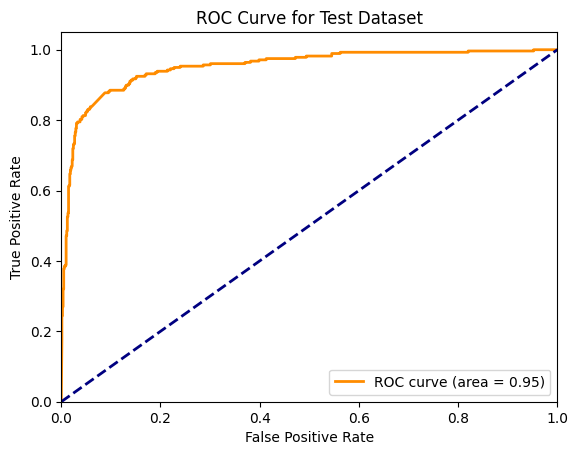

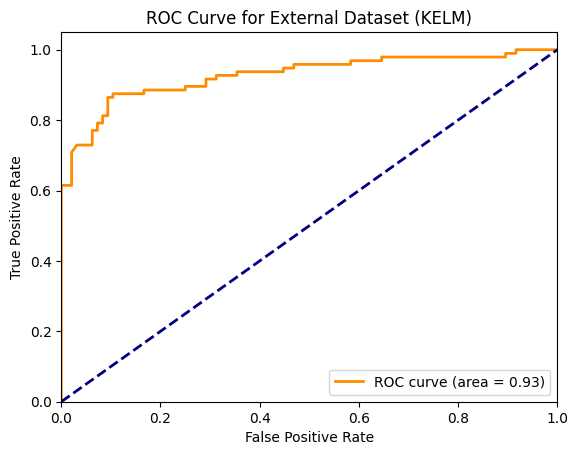

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_probas, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probas)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curve for the test dataset
plot_roc_curve(y_test, predicted_probas_test, title='ROC Curve for Test Dataset')

# Plot ROC curve for the external dataset
plot_roc_curve(y_external, predicted_probas_ext, title='ROC Curve for External Dataset (KELM)')


In [32]:
import pandas as pd

# Example saving for the test dataset
df_test = pd.DataFrame({
    'False Positive Rate': fpr_test,
    'True Positive Rate': tpr_test,
    'ROC AUC': [roc_auc_test] * len(fpr_test)  # AUC is constant across the curve
})
df_test.to_csv('ESM-640_test_dataset_roc_values.csv', index=False)

# Example saving for the external dataset
df_ext = pd.DataFrame({
    'False Positive Rate': fpr_ext,
    'True Positive Rate': tpr_ext,
    'ROC AUC': [roc_auc_ext] * len(fpr_ext)  # AUC is constant across the curve
})
df_ext.to_csv('ESM-640_external_dataset_roc_values.csv', index=False)


NameError: name 'fpr_test' is not defined